In [1]:
# pip install torch

The objective of this project is to develop a deep learning model for the classification of medical brain images to detect the presence of tumors. The approach involves utilizing transfer learning, where an initial Convolutional Neural Network (CNN) will be trained on the dataset to extract relevant features. Subsequently, knowledge from this trained model will be transferred to a more advanced ResNet architecture, enhancing its performance and generalization capability. This methodology aims to leverage the strengths of both traditional CNNs and state-of-the-art deep learning architectures for improved tumor classification accuracy.

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
from IPython import get_ipython
from IPython.display import display

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim

In [5]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.models import ResNet18_Weights, resnet18

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc


In [7]:
import time
import copy

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="D:\MAGISTERKA\PRACA\logs")

In [9]:
df= pd.read_csv('D:\MAGISTERKA\PRACA\metadata.csv')

In [10]:
df.head(5)

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [11]:
print(df['format'].value_counts())

format
JPEG    4496
TIFF      86
PNG       18
Name: count, dtype: int64


due to low amount, all non JPEG files are deleted

In [12]:
df= df[df['format'] == 'JPEG']


In [13]:
print(df['format'].value_counts())

format
JPEG    4496
Name: count, dtype: int64


In [14]:
df_jpg = df[df['image'].str.lower().str.endswith('.jpg')]


In [15]:
df_jpg

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
5,5,Cancer (100).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
6,6,Cancer (1000).jpg,tumor,JPEG,RGB,"(290, 250, 3)"
7,7,Cancer (1001).jpg,tumor,JPEG,RGB,"(620, 620, 3)"
...,...,...,...,...,...,...
4595,4595,Not Cancer (995).jpg,normal,JPEG,RGB,"(168, 300, 3)"
4596,4596,Not Cancer (996).jpg,normal,JPEG,RGB,"(509, 452, 3)"
4597,4597,Not Cancer (997).jpg,normal,JPEG,RGB,"(197, 177, 3)"
4598,4598,Not Cancer (998).jpg,normal,JPEG,RGB,"(217, 232, 3)"


The data preparation and preprocessing phase will involve curating and adapting the dataset for training. Initially, a small test dataset will be used, consisting of approximately 50 images per class. This preliminary step will help evaluate the effectiveness of the preprocessing techniques and model performance before scaling up to a larger dataset.

In [16]:
train_df, val_df = train_test_split(df_jpg, test_size=0.2, random_state=42, stratify=df_jpg['class'])

In [17]:
print("train:", len(train_df), "val:", len(val_df))

train: 3592 val: 898


In [37]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [38]:
def is_jpg(filename):
  return filename.lower().endswith('.jpg')

In [39]:
data_dir='D:\MAGISTERKA\PRACA\dataset'

In [40]:
train_dataset= ImageFolder(
    root=data_dir,
    transform= data_transforms['train'],
    is_valid_file= is_jpg
)

val_dataset= ImageFolder(
    root=data_dir,
    transform= data_transforms['val'],
    is_valid_file= is_jpg
)

In [41]:
indices= np.arange(len(train_dataset))
targets=train_dataset.targets

In [42]:
train_indices, val_indices= train_test_split(indices, test_size=0.2, stratify=targets, random_state=42)

In [43]:
train_set=Subset(train_dataset, train_indices)
val_set= Subset(val_dataset, val_indices)

In [44]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)

The pretrained AlexNet model is utilized in this phase, where it is adapted to the specific requirements of the project. Necessary modifications are applied to align the architecture with the task of brain tumor classification, ensuring optimal feature extraction and performance.

In [45]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

In [46]:
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)

In [47]:
num_epochs = 50

best_acc = 0.0
best_model_wts = copy.deepcopy(alexnet.state_dict())

In [48]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [49]:
start_time = time.time()
for epoch in range(num_epochs):
    print(f" Epoch {epoch+1}/{num_epochs}")

    for phase in ["train", "val"]:
        if phase == "train":
            alexnet.train()
            dataloader = train_loader
        else:
            alexnet.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                outputs = alexnet(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print(f" {phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == "train":
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc.item())


torch.save(alexnet.state_dict(), "alexnet_xray.pth")
print(" Model saved as alexnet_xray.pth")

 Epoch 1/50
 Train Loss: 0.2451 Acc: 0.8971
 Val Loss: 0.1094 Acc: 0.9490
 Epoch 2/50
 Train Loss: 0.0750 Acc: 0.9731
 Val Loss: 0.0818 Acc: 0.9712
 Epoch 3/50
 Train Loss: 0.0469 Acc: 0.9845
 Val Loss: 0.1485 Acc: 0.9424
 Epoch 4/50
 Train Loss: 0.0351 Acc: 0.9886
 Val Loss: 0.0690 Acc: 0.9756
 Epoch 5/50
 Train Loss: 0.0335 Acc: 0.9914
 Val Loss: 0.1055 Acc: 0.9734
 Epoch 6/50
 Train Loss: 0.0384 Acc: 0.9867
 Val Loss: 0.0388 Acc: 0.9900
 Epoch 7/50
 Train Loss: 0.0207 Acc: 0.9931
 Val Loss: 0.0692 Acc: 0.9767
 Epoch 8/50
 Train Loss: 0.0121 Acc: 0.9958
 Val Loss: 0.0823 Acc: 0.9800
 Epoch 9/50
 Train Loss: 0.0178 Acc: 0.9942
 Val Loss: 0.0512 Acc: 0.9878
 Epoch 10/50
 Train Loss: 0.0094 Acc: 0.9964
 Val Loss: 0.0478 Acc: 0.9900
 Epoch 11/50
 Train Loss: 0.0104 Acc: 0.9967
 Val Loss: 0.0388 Acc: 0.9945
 Epoch 12/50
 Train Loss: 0.0238 Acc: 0.9936
 Val Loss: 0.0675 Acc: 0.9834
 Epoch 13/50
 Train Loss: 0.0010 Acc: 1.0000
 Val Loss: 0.0505 Acc: 0.9933
 Epoch 14/50
 Train Loss: 0.0006 A

In [50]:
alexnet.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        probs = torch.softmax(outputs, dim=1)[:, 1]

        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

NameError: name 'model' is not defined

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.xlabel("Predicted templates")
plt.ylabel("True templates")
plt.title("Confusion matrix")
plt.show()


fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC")
plt.legend(loc="lower right")
plt.show()

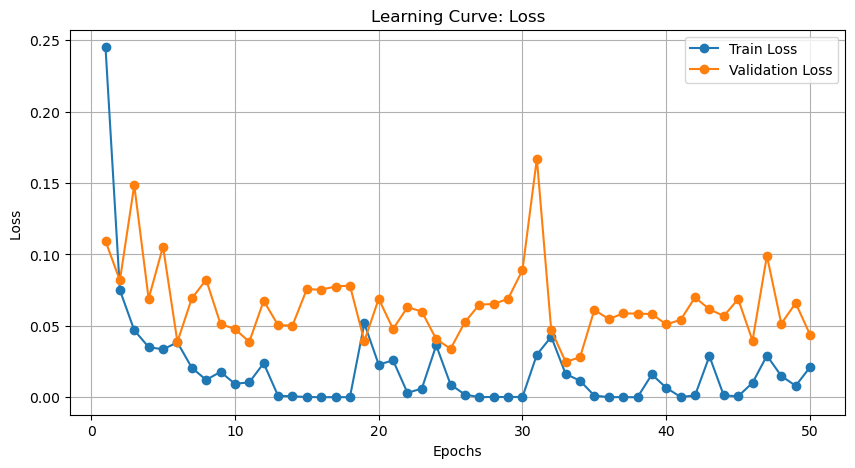

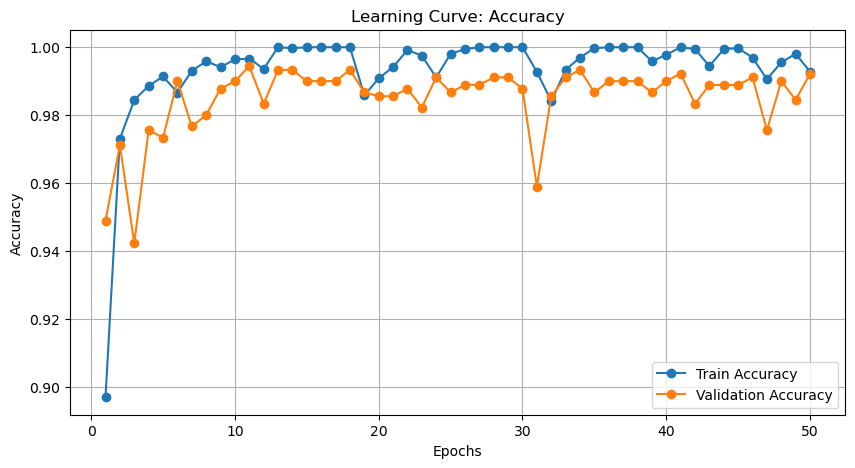

In [51]:
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.title('Learning Curve: Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accs, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accs, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Accuracy")
plt.legend()
plt.grid()
plt.show()

Resnet part - no transfer learning yet

In [ ]:
# model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
num_epochs = 10

In [ ]:
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

In [ ]:
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}/{num_epochs}")
#     print("-" * 10)

#     for phase in ['train', 'val']:
#         if phase == 'train':
#             model.train()
#             dataloader = train_loader
#         else:
#             model.eval()
#             dataloader = val_loader

#         running_loss = 0.0
#         running_corrects = 0

#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()

#             with torch.set_grad_enabled(phase == 'train'):
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 _, preds = torch.max(outputs, 1)

#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(dataloader.dataset)
#         epoch_acc = running_corrects.double() / len(dataloader.dataset)

#         print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

#         if phase == 'val' and epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = copy.deepcopy(model.state_dict())

#     writer.add_scalar(f'{phase} Loss', epoch_loss, epoch)
#     writer.add_scalar(f'{phase} Acc', epoch_acc, epoch)
#     writer.close()

#     print()

# print(f"Best accuracy on vlaidation dataset: {best_acc:.4f}")


# model.load_state_dict(best_model_wts)

# # torch.save(model.state_dict(), "resnet_xray_best.pth")
# print("Model saved as resnet_xray_best.pth")

data visualization

In [ ]:
# model.eval()

# all_labels = []
# all_preds = []
# all_probs = []

# with torch.no_grad():
#     for inputs, labels in val_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = model(inputs)

#         probs = torch.softmax(outputs, dim=1)[:, 1]

#         _, preds = torch.max(outputs, 1)

#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(preds.cpu().numpy())
#         all_probs.extend(probs.cpu().numpy())

In [ ]:
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(6,6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
# plt.xlabel("Predicted templates")
# plt.ylabel("True templates")
# plt.title("Confusion matrix")
# plt.show()


# fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8,6))
# plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC (AUC = %0.2f)" % roc_auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title(" ROC")
# plt.legend(loc="lower right")
# plt.show()